https://docs.ultralytics.com/modes/predict/#inference-arguments

In [110]:
import os
import xml.etree.ElementTree as ET
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np
import random
import shutil
from ultralytics import YOLO
from IPython.display import display, Image
import matplotlib.pyplot as plt
import matplotlib.image as mpimg



# Convert the dataset to Yolov8 format

In [16]:

# Define paths
images_dir = 'dataset/JPEGImages'
annotations_dir = 'dataset/Annotations'
output_dir = 'dataset/YOLOv8'

class_mapping = {
    'golffield': 0,
    'Expressway-toll-station': 1,
    'vehicle': 2,
    'trainstation': 3,
    'chimney': 4,
    'storagetank': 5,
    'ship': 6,
    'harbor': 7,
    'airplane': 8,
    'groundtrackfield': 9,
    'tenniscourt': 10,
    'dam': 11,
    'basketballcourt': 12,
    'Expressway-Service-area': 13,
    'stadium': 14,
    'airport': 15,
    'baseballfield': 16,
    'bridge': 17,
    'windmill': 18,
    'overpass': 19
}

# Create output directory if not exists
os.makedirs(output_dir, exist_ok=True)


In [3]:
# Define paths

# Function to convert bounding box coordinates to YOLO format
def convert_coordinates(size, box):
    dw = 1.0 / size[0]
    dh = 1.0 / size[1]
    x = (box[0] + box[1]) / 2.0
    y = (box[2] + box[3]) / 2.0
    w = box[1] - box[0]
    h = box[3] - box[2]
    x = x * dw
    w = w * dw
    y = y * dh
    h = h * dh
    return (x, y, w, h)

# Iterate through each annotation file in the dataset
for annotation_file in os.listdir(annotations_dir):
    if not annotation_file.endswith('.xml'):
        continue
    
    xml_path = os.path.join(annotations_dir, annotation_file)
    output_annotation_path = os.path.join(output_dir, os.path.splitext(annotation_file)[0] + '.txt')

    # Parse XML file
    tree = ET.parse(xml_path)
    root = tree.getroot()

    size = root.find('size')
    width = int(size.find('width').text)
    height = int(size.find('height').text)

    # Write YOLO formatted annotations to output file
    with open(output_annotation_path, 'w') as f:
        for obj in root.iter('object'):
            cls = obj.find('name').text
            if cls not in class_mapping:
                continue
            cls_id = class_mapping[cls]
            xmlbox = obj.find('bndbox')
            xmin = float(xmlbox.find('xmin').text)
            ymin = float(xmlbox.find('ymin').text)
            xmax = float(xmlbox.find('xmax').text)
            ymax = float(xmlbox.find('ymax').text)

            # Convert bounding box coordinates to YOLO format
            bbox = (xmin, xmax, ymin, ymax)
            bbox_yolo = convert_coordinates((width, height), bbox)

            # Write YOLO formatted annotation to output file
            f.write(f"{cls_id} {' '.join([str(coord) for coord in bbox_yolo])}\n")

print("Conversion to YOLOv8 format completed.")
print("Class Mapping:")
print(class_mapping)


Conversion to YOLOv8 format completed.
Class Mapping:
{'golffield': 0, 'Expressway-toll-station': 1, 'vehicle': 2, 'trainstation': 3, 'chimney': 4, 'storagetank': 5, 'ship': 6, 'harbor': 7, 'airplane': 8, 'groundtrackfield': 9, 'tenniscourt': 10, 'dam': 11, 'basketballcourt': 12, 'Expressway-Service-area': 13, 'stadium': 14, 'airport': 15, 'baseballfield': 16, 'bridge': 17, 'windmill': 18, 'overpass': 19}



# EDA

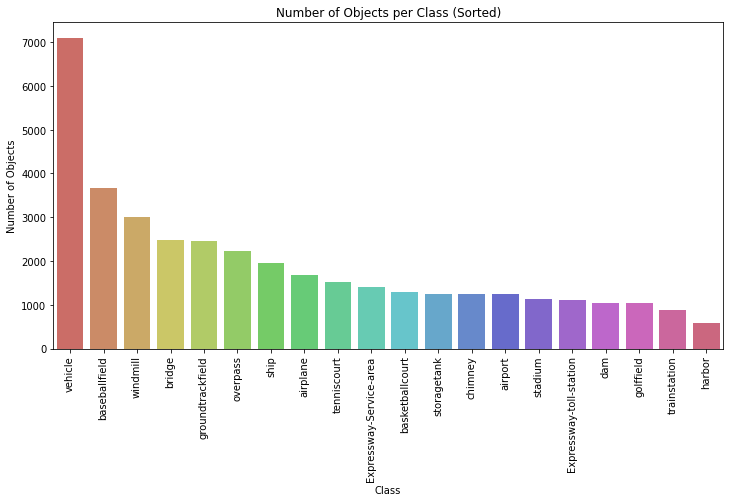

In [25]:
# Initialize dictionary to store counts for each class
class_counts = {class_name: 0 for class_name in class_mapping}

# Iterate through each annotation file in the dataset
for annotation_file in os.listdir(annotations_dir):
    if not annotation_file.endswith('.xml'):
        continue
    
    xml_path = os.path.join(annotations_dir, annotation_file)

    # Parse XML file
    tree = ET.parse(xml_path)
    root = tree.getroot()

    # Update class count
    for obj in root.iter('object'):
        cls = obj.find('name').text
        if cls in class_mapping:
            class_counts[cls] += 1

# Sort classes based on number of objects
sorted_class_counts = dict(sorted(class_counts.items(), key=lambda item: item[1], reverse=True))

# Plot number of instances per class with different colors
plt.figure(figsize=(12, 6))
sns.barplot(x=list(sorted_class_counts.keys()), y=list(sorted_class_counts.values()), palette="hls")
plt.title('Number of Objects per Class (Sorted)')
plt.xlabel('Class')
plt.ylabel('Number of Objects')
plt.xticks(rotation=90)
plt.show()

# splitting the images and YOLOv8 annotations into three folders for training, validation, and testing


In [ ]:


# Define paths
train_dir = 'train'
val_dir = 'val'
test_dir = 'test'

# Define subfolder names
subfolders = ['images', 'labels']

# Define split ratios (train:val:test)
split_ratios = [0.7, 0.15, 0.15]

# Create train, val, and test directories if they don't exist
for directory in [train_dir, val_dir, test_dir]:
    os.makedirs(os.path.join(directory, subfolders[0]), exist_ok=True)  # Images
    os.makedirs(os.path.join(directory, subfolders[1]), exist_ok=True)  # Labels

# Get list of image files
image_files = os.listdir(images_dir)
random.shuffle(image_files)

# Calculate number of images for each split
total_images = len(image_files)
num_train = int(split_ratios[0] * total_images)
num_val = int(split_ratios[1] * total_images)
num_test = total_images - num_train - num_val

# Copy images and annotations to train, val, and test directories
for i, split in enumerate([train_dir, val_dir, test_dir]):
    start_index = sum([int(r * total_images) for r in split_ratios[:i]])
    end_index = start_index + (num_train if split == train_dir else (num_val if split == val_dir else num_test))
    
    for image_file in image_files[start_index:end_index]:
        # Copy image file
        shutil.copy(os.path.join(images_dir, image_file), os.path.join(split, subfolders[0], image_file))
        
        # Copy corresponding annotation file
        annotation_file = os.path.splitext(image_file)[0] + '.txt'
        shutil.copy(os.path.join(output_dir, annotation_file), os.path.join(split, subfolders[1], annotation_file))

print("Dataset split into train, val, and test folders with images and labels subfolders.")


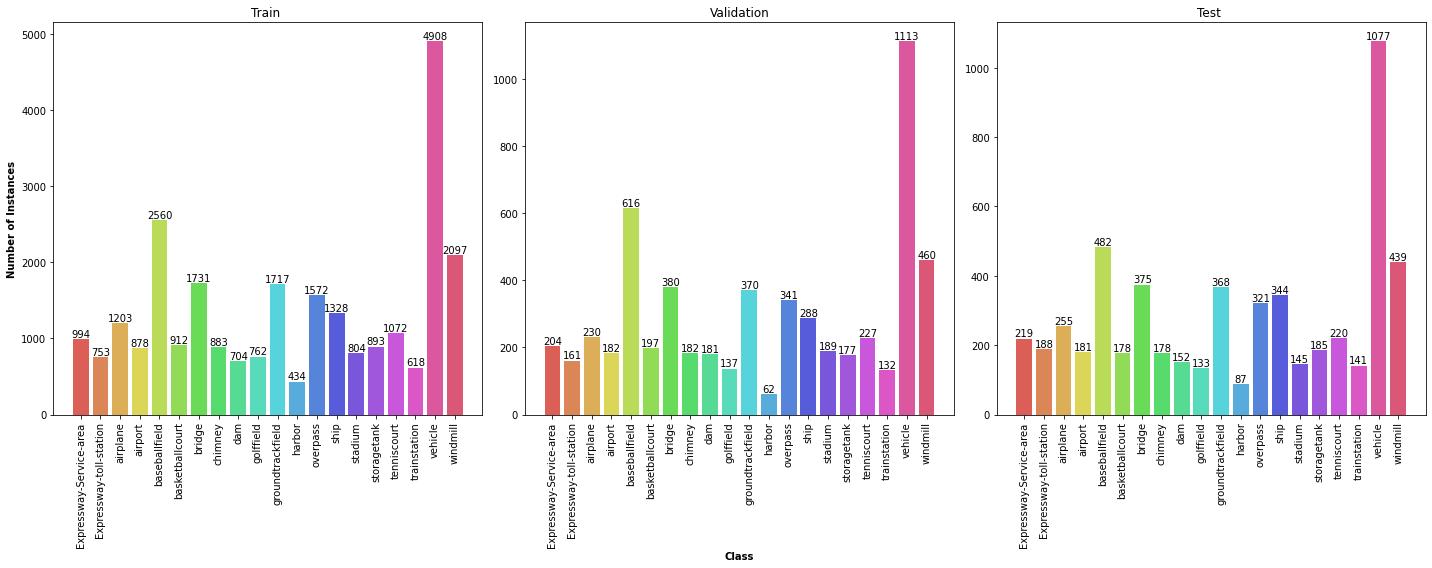

In [39]:
# Sort class counts dictionaries by keys (class names)
train_class_counts_sorted = dict(sorted(train_class_counts.items()))
val_class_counts_sorted = dict(sorted(val_class_counts.items()))
test_class_counts_sorted = dict(sorted(test_class_counts.items()))

# Plot the number of instances for each class in each folder
# Plot the number of instances for each class in each folder
plt.figure(figsize=(20, 8))

# Train folder subplot
plt.subplot(1, 3, 1)
plt.bar(sorted_train_class_counts.keys(), sorted_train_class_counts.values(), color=sns.color_palette("hls", len(train_class_counts)))
plt.title('Train ')
#plt.xlabel('Class')
plt.ylabel('Number of Instances', fontweight='bold')
plt.xticks(rotation=90)
for key, value in sorted_train_class_counts.items():
    plt.text(key, value, str(value), ha='center', va='bottom')

# Validation folder subplot
plt.subplot(1, 3, 2)
plt.bar(sorted_val_class_counts.keys(), sorted_val_class_counts.values(), color=sns.color_palette("hls", len(val_class_counts)))
plt.title('Validation')
plt.xlabel('Class',fontweight='bold')
#plt.ylabel('Number of Instances')
plt.xticks(rotation=90)
for key, value in sorted_val_class_counts.items():
    plt.text(key, value, str(value), ha='center', va='bottom')

# Test folder subplot
plt.subplot(1, 3, 3)
plt.bar(sorted_test_class_counts.keys(), sorted_test_class_counts.values(), color=sns.color_palette("hls", len(test_class_counts)))
plt.title('Test ')
#plt.xlabel('Class')
#plt.ylabel('Number of Instances')
plt.xticks(rotation=90)
for key, value in sorted_test_class_counts.items():
    plt.text(key, value, str(value), ha='center', va='bottom')

plt.tight_layout()
plt.show()


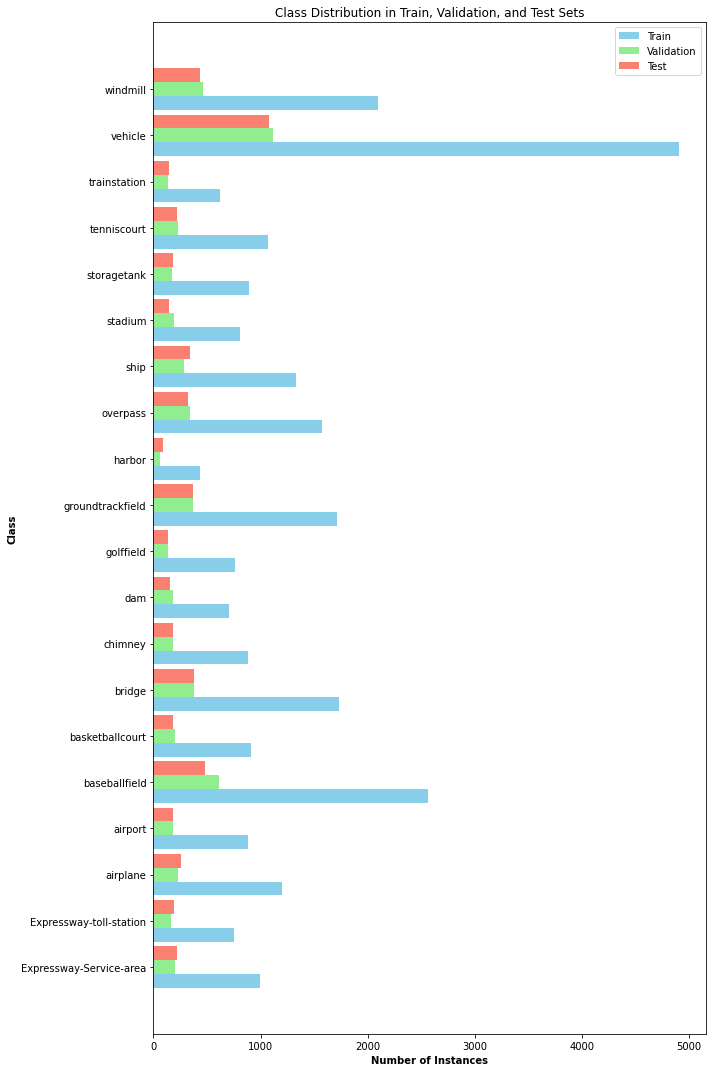

In [46]:
# Plot the number of instances for each class in each folder
plt.figure(figsize=(10, 15))

# Plot bars for each class
class_names = sorted(train_class_counts.keys())
num_classes = len(class_names)
bar_height = 0.3
index = np.arange(num_classes)

# Train bars
plt.barh(index, sorted_train_class_counts.values(), bar_height, label='Train', color='skyblue')
# Validation bars
plt.barh(index + bar_height, sorted_val_class_counts.values(), bar_height, label='Validation', color='lightgreen')
# Test bars
plt.barh(index + 2 * bar_height, sorted_test_class_counts.values(), bar_height, label='Test', color='salmon')

plt.title('Class Distribution in Train, Validation, and Test Sets')
plt.xlabel('Number of Instances', fontweight='bold')
plt.ylabel('Class', fontweight='bold')
plt.yticks(index + bar_height, class_names)
plt.legend()

plt.tight_layout()
plt.show()


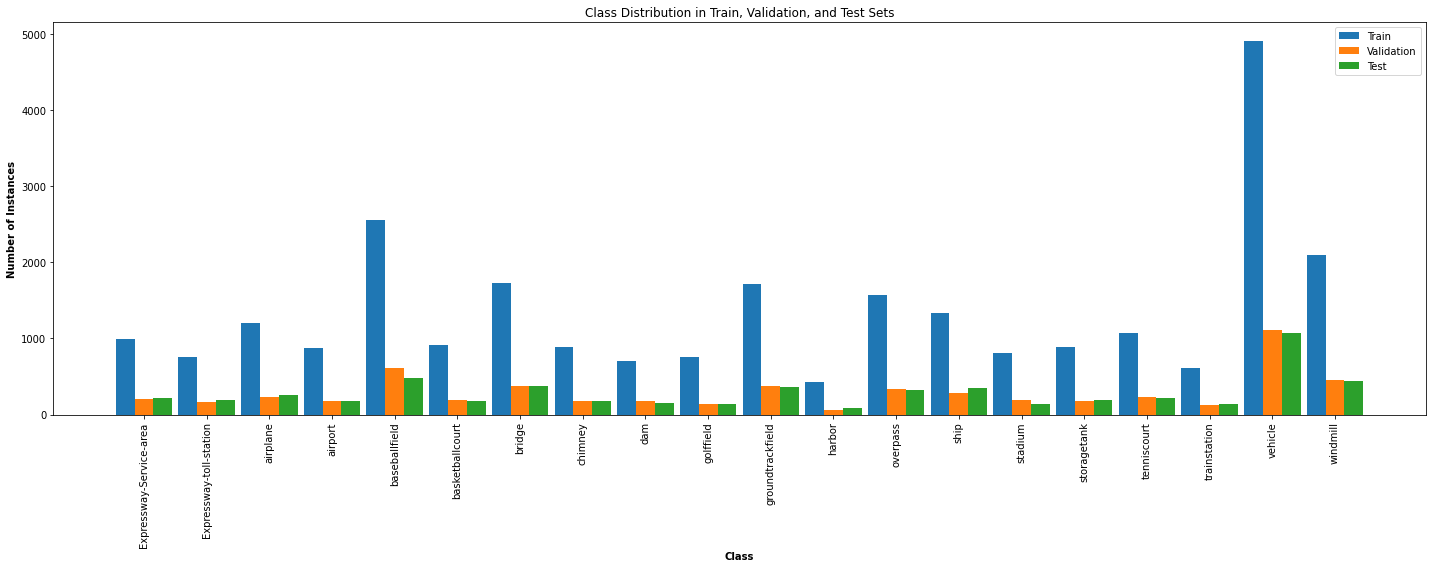

In [48]:
# Plot the number of instances for each class in each folder
plt.figure(figsize=(20, 8))

# Plot bars for each class
class_names = sorted(train_class_counts.keys())
num_classes = len(class_names)
bar_width = 0.3
index = np.arange(num_classes)

# Train bars
plt.bar(index, sorted_train_class_counts.values(), bar_width, label='Train')
# Validation bars
plt.bar(index + bar_width, sorted_val_class_counts.values(), bar_width, label='Validation')
# Test bars
plt.bar(index + 2 * bar_width, sorted_test_class_counts.values(), bar_width, label='Test')

plt.title('Class Distribution in Train, Validation, and Test Sets')
plt.xlabel('Class', fontweight='bold')
plt.ylabel('Number of Instances', fontweight='bold')
plt.xticks(index + bar_width, class_names, rotation=90)
plt.legend()

plt.tight_layout()
plt.show()


# YoloV8 Modelling

# Training 

In [50]:
model=YOLO("yolov8n.yaml")

In [59]:
results=model.train(data="dataset/data/data.yaml", epochs=10)

New https://pypi.org/project/ultralytics/8.1.29 available 😃 Update with 'pip install -U ultralytics'
Ultralytics YOLOv8.1.28 🚀 Python-3.9.12 torch-2.0.1+cpu CPU (AMD Ryzen 7 5700U with Radeon Graphics)
engine\trainer: task=detect, mode=train, model=yolov8n.yaml, data=dataset/data/data.yaml, epochs=10, time=None, patience=100, batch=16, imgsz=640, save=True, save_period=-1, cache=False, device=None, workers=8, project=None, name=train, exist_ok=False, pretrained=True, optimizer=auto, verbose=True, seed=0, deterministic=True, single_cls=False, rect=False, cos_lr=False, close_mosaic=10, resume=False, amp=True, fraction=1.0, profile=False, freeze=None, multi_scale=False, overlap_mask=True, mask_ratio=4, dropout=0.0, val=True, split=val, save_json=False, save_hybrid=False, conf=None, iou=0.7, max_det=300, half=False, dnn=False, plots=True, source=None, vid_stride=1, stream_buffer=False, visualize=False, augment=False, agnostic_nms=False, classes=None, retina_masks=False, embed=None, show=Fa

train: Scanning C:\Users\Oraib\YoloDior\dataset\data\train\labels.cache... 12181 images, 0 backgrounds, 0 corrupt: 100%
val: Scanning C:\Users\Oraib\YoloDior\dataset\data\valid\labels.cache... 2610 images, 0 backgrounds, 0 corrupt: 100%|██

Plotting labels to runs\detect\train\labels.jpg... 


optimizer: 'optimizer=auto' found, ignoring 'lr0=0.01' and 'momentum=0.937' and determining best 'optimizer', 'lr0' and 'momentum' automatically... 
optimizer: AdamW(lr=0.000417, momentum=0.9) with parameter groups 57 weight(decay=0.0), 64 weight(decay=0.0005), 63 bias(decay=0.0)
TensorBoard: model graph visualization added ✅
Image sizes 640 train, 640 val
Using 0 dataloader workers
Logging results to runs\detect\train
Starting training for 10 epochs...
Closing dataloader mosaic

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


       1/10         0G      3.136      5.675      4.016         18        640: 100%|██████████| 762/762 [1:05:57<00:00,
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 82/82 [05:55


                   all       2610       5829      0.484     0.0207     0.0154    0.00579

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


       2/10         0G      2.617      4.548      3.117          8        640: 100%|██████████| 762/762 [1:04:20<00:00,
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 82/82 [05:54


                   all       2610       5829      0.593      0.117      0.105     0.0535

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


       3/10         0G      2.194      3.487      2.595         11        640: 100%|██████████| 762/762 [1:04:21<00:00,
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 82/82 [05:55


                   all       2610       5829      0.402      0.226      0.198      0.107

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


       4/10         0G       1.97      2.875      2.329          9        640: 100%|██████████| 762/762 [1:04:22<00:00,
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 82/82 [05:53


                   all       2610       5829      0.376      0.303      0.262      0.147

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


       5/10         0G      1.848      2.536      2.166         11        640: 100%|██████████| 762/762 [1:04:17<00:00,
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 82/82 [05:52


                   all       2610       5829      0.442      0.341      0.313      0.179

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


       6/10         0G      1.739      2.278      2.041         11        640: 100%|██████████| 762/762 [1:04:17<00:00,
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 82/82 [05:51


                   all       2610       5829      0.488      0.378      0.363      0.215

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


       7/10         0G       1.67      2.118      1.953         12        640: 100%|██████████| 762/762 [1:04:20<00:00,
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 82/82 [05:53


                   all       2610       5829      0.518      0.421      0.403      0.242

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


       8/10         0G      1.605       1.98      1.884         10        640: 100%|██████████| 762/762 [1:04:19<00:00,
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 82/82 [05:52


                   all       2610       5829      0.557      0.431       0.43      0.264

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


       9/10         0G      1.563      1.886       1.83         12        640: 100%|██████████| 762/762 [1:04:21<00:00,
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 82/82 [05:51


                   all       2610       5829      0.572      0.466      0.455      0.284

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      10/10         0G      1.522      1.806      1.789          7        640: 100%|██████████| 762/762 [1:07:22<00:00,
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 82/82 [06:06


                   all       2610       5829      0.607      0.479      0.481      0.303

10 epochs completed in 11.790 hours.
Optimizer stripped from runs\detect\train\weights\last.pt, 6.3MB
Optimizer stripped from runs\detect\train\weights\best.pt, 6.3MB

Validating runs\detect\train\weights\best.pt...
Ultralytics YOLOv8.1.28 🚀 Python-3.9.12 torch-2.0.1+cpu CPU (AMD Ryzen 7 5700U with Radeon Graphics)
YOLOv8n summary (fused): 168 layers, 3009548 parameters, 0 gradients, 8.1 GFLOPs


                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 82/82 [04:51


                   all       2610       5829      0.608       0.48      0.482      0.303
             golffield       2610        137      0.565      0.292      0.362      0.158
Expressway-toll-station       2610        161      0.714       0.41      0.475      0.353
               vehicle       2610       1113      0.702      0.296      0.398      0.197
          trainstation       2610        132       0.16       0.25      0.121     0.0406
               chimney       2610        182      0.767       0.72       0.77      0.541
           storagetank       2610        177      0.761      0.678      0.697      0.585
                  ship       2610        288      0.407      0.417      0.348       0.17
                harbor       2610         62          1          0     0.0471     0.0251
              airplane       2610        230      0.647       0.83      0.731       0.49
      groundtrackfield       2610        370      0.651      0.611      0.647      0.452
           tenniscou

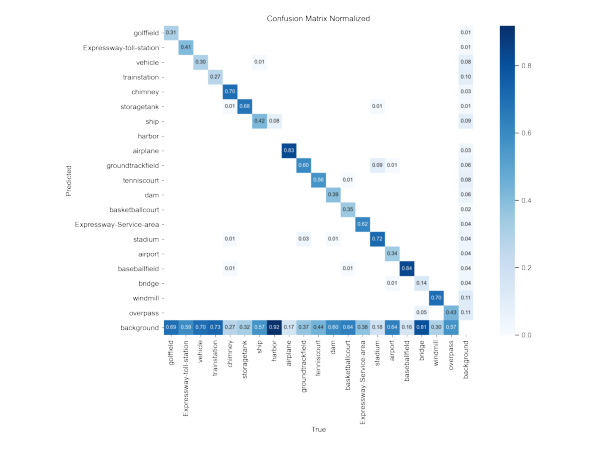

In [103]:
image_path = r'C:\Users\Oraib\YoloDior\runs\detect\train\confusion_matrix_normalized.png'

# Read the image file
image = mpimg.imread(image_path)

# Display the image
plt.figure(figsize=(15, 8))
plt.imshow(image)
plt.axis('off')  # Turn off axis labels
plt.show()

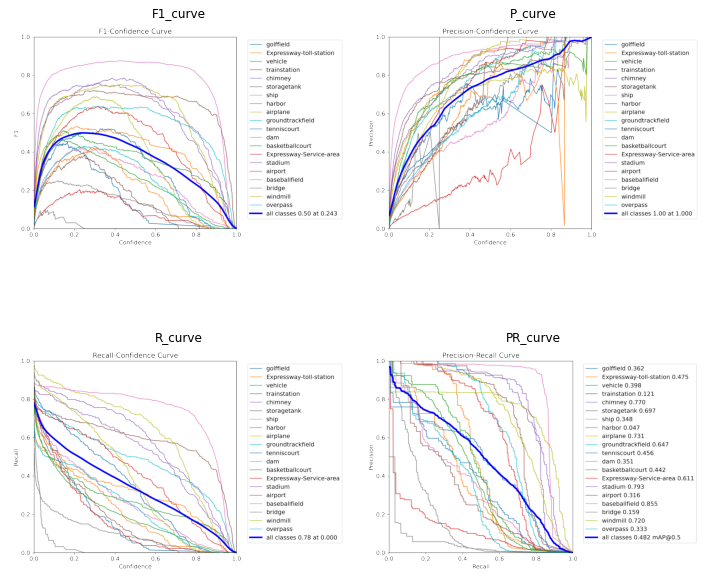

In [111]:
import os
import matplotlib.pyplot as plt
import matplotlib.image as mpimg

# Specify the directory containing the PNG images
images_directory = r'C:\Users\Oraib\YoloDior\runs\detect\train'

# List of image filenames
image_filenames = ['F1_curve.png', 'P_curve.png', 'R_curve.png', 'PR_curve.png']

# Create a 2x2 grid of subplots
fig, axs = plt.subplots(2, 2, figsize=(10, 10))

# Iterate over the image filenames and display each image in a subplot
for i, image_filename in enumerate(image_filenames):
    # Calculate subplot indices
    row_index = i // 2
    col_index = i % 2

    # Construct the full path to the image file
    image_path = os.path.join(images_directory, image_filename)

    # Read the image file
    image = mpimg.imread(image_path)

    # Display the image in the corresponding subplot
    axs[row_index, col_index].imshow(image)
    axs[row_index, col_index].axis('off')  # Turn off axis labels

    # Set subplot title
    axs[row_index, col_index].set_title(image_filename[:-4])  # Remove the file extension (.png)

# Adjust layout to prevent overlap of subplots
plt.tight_layout()

# Show the plot
plt.show()


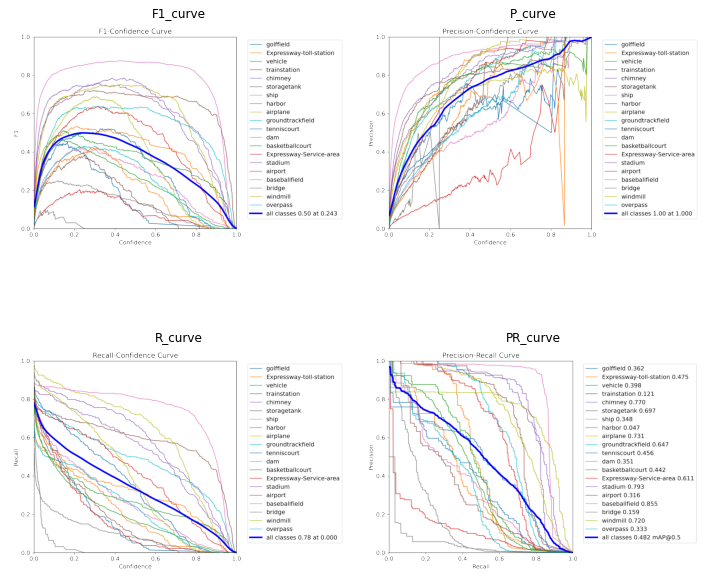

In [113]:


# Specify the directory containing the PNG images
images_directory = r'C:\Users\Oraib\YoloDior\runs\detect\train'

# List of image filenames
image_filenames = ['F1_curve.png', 'P_curve.png', 'R_curve.png', 'PR_curve.png']

# Create a 2x2 grid of subplots
fig, axs = plt.subplots(2, 2, figsize=(10, 10))

# Iterate over the image filenames and display each image in a subplot
for i, image_filename in enumerate(image_filenames):
    # Calculate subplot indices
    row_index = i // 2
    col_index = i % 2

    # Construct the full path to the image file
    image_path = os.path.join(images_directory, image_filename)

    # Read the image file
    image = mpimg.imread(image_path)

    # Display the image in the corresponding subplot
    axs[row_index, col_index].imshow(image)
    axs[row_index, col_index].axis('off')  # Turn off axis labels

    # Set subplot title
    axs[row_index, col_index].set_title(image_filename[:-4])  # Remove the file extension (.png)

# Adjust layout to prevent overlap of subplots
plt.tight_layout()

# Show the plot
plt.show()


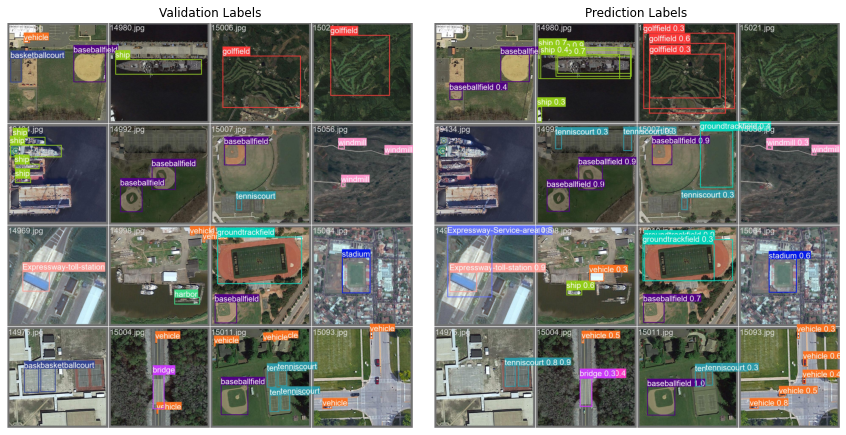

In [109]:

# Specify the paths to the images
val_labels_image_path = r'C:\Users\Oraib\YoloDior\runs\detect\train\val_batch0_labels.jpg'
pred_labels_image_path = r'C:\Users\Oraib\YoloDior\runs\detect\train\val_batch0_pred.jpg'

# Read the images
val_labels_image = mpimg.imread(val_labels_image_path)
pred_labels_image = mpimg.imread(pred_labels_image_path)

# Create a figure with two subplots side by side
fig, axs = plt.subplots(1, 2, figsize=(12, 6))

# Plot the first image (validation labels)
axs[0].imshow(val_labels_image)
axs[0].set_title('Validation Labels')
axs[0].axis('off')

# Plot the second image (prediction labels)
axs[1].imshow(pred_labels_image)
axs[1].set_title('Prediction Labels')
axs[1].axis('off')

# Adjust layout to prevent overlap of subplots
plt.tight_layout()

# Show the plot
plt.show()


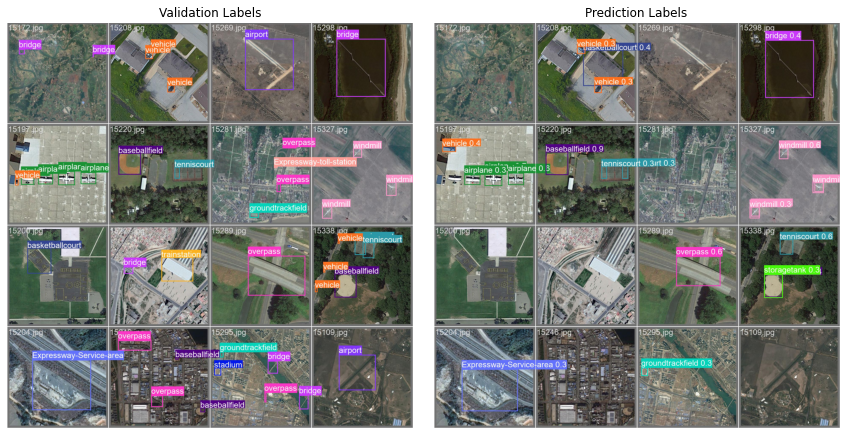

In [115]:

# Specify the paths to the images
val_labels_image_path = r'C:\Users\Oraib\YoloDior\runs\detect\train\val_batch2_labels.jpg'
pred_labels_image_path = r'C:\Users\Oraib\YoloDior\runs\detect\train\val_batch2_pred.jpg'

# Read the images
val_labels_image = mpimg.imread(val_labels_image_path)
pred_labels_image = mpimg.imread(pred_labels_image_path)

# Create a figure with two subplots side by side
fig, axs = plt.subplots(1, 2, figsize=(12, 6))

# Plot the first image (validation labels)
axs[0].imshow(val_labels_image)
axs[0].set_title('Validation Labels')
axs[0].axis('off')

# Plot the second image (prediction labels)
axs[1].imshow(pred_labels_image)
axs[1].set_title('Prediction Labels')
axs[1].axis('off')

# Adjust layout to prevent overlap of subplots
plt.tight_layout()

# Show the plot
plt.show()


# Test dataset

In [74]:
 #Loading the best weights
model = YOLO('runs/detect/train/weights/best.pt')


In [87]:
# Specify the path to the directory containing the test images
test_images_directory = r'C:\Users\Oraib\YoloDior\dataset\data\test\images'

# Use the model for prediction, specifying the data and source parameters
test_results = model.predict(source=test_images_directory, save_txt=True, save=True)




WARNING ⚠️ inference results will accumulate in RAM unless `stream=True` is passed, causing potential out-of-memory
errors for large sources or long-running streams and videos. See https://docs.ultralytics.com/modes/predict/ for help.

Example:
    results = model(source=..., stream=True)  # generator of Results objects
    for r in results:
        boxes = r.boxes  # Boxes object for bbox outputs
        masks = r.masks  # Masks object for segment masks outputs
        probs = r.probs  # Class probabilities for classification outputs

image 1/2611 C:\Users\Oraib\YoloDior\dataset\data\test\images\00006.jpg: 640x640 1 ship, 174.9ms
image 2/2611 C:\Users\Oraib\YoloDior\dataset\data\test\images\00014.jpg: 640x640 4 storagetanks, 115.2ms
image 3/2611 C:\Users\Oraib\YoloDior\dataset\data\test\images\00021.jpg: 640x640 (no detections), 99.7ms
image 4/2611 C:\Users\Oraib\YoloDior\dataset\data\test\images\00033.jpg: 640x640 3 ships, 107.0ms
image 5/2611 C:\Users\Oraib\YoloDior\dataset\data\t

In [91]:
import os
import random
from PIL import Image
import numpy as np

# Set the path to the directory containing the images
image_directory = r'C:\Users\Oraib\YoloDior\runs\detect\predict'

# Get the list of image filenames in the directory
image_filenames = [filename for filename in os.listdir(image_directory) if filename.endswith('.jpg')]

# Define the number of batches
num_batches = 5

# Create batches
for batch_num in range(num_batches):
    # Randomly select 16 unique image filenames
    batch_image_filenames = random.sample(image_filenames, 16)
    
    # Create a new blank image for the batch
    batch_image = Image.new('RGB', (800, 800))
    
    # Paste each selected image into the batch image
    for i, image_filename in enumerate(batch_image_filenames):
        # Open the image
        image_path = os.path.join(image_directory, image_filename)
        image = Image.open(image_path)
        
        # Resize the image to fit into a 4x4 grid
        image = image.resize((200, 200))
        
        # Calculate the position to paste the image
        row = i // 4
        col = i % 4
        position = (col * 200, row * 200)
        
        # Paste the image into the batch image
        batch_image.paste(image, position)
    
    # Save the batch image
    batch_image.save(f'test_batch_{batch_num + 1}.jpg')


In [ ]:

# Specify the paths to the images
val_labels_image_path = r'C:\Users\Oraib\YoloDior\runs\detect\train\val_batch2_labels.jpg'
pred_labels_image_path = r'C:\Users\Oraib\YoloDior\runs\detect\train\val_batch2_pred.jpg'

# Read the images
val_labels_image = mpimg.imread(val_labels_image_path)
pred_labels_image = mpimg.imread(pred_labels_image_path)

# Create a figure with two subplots side by side
fig, axs = plt.subplots(1, 2, figsize=(12, 6))

# Plot the first image (validation labels)
axs[0].imshow(val_labels_image)
axs[0].set_title('Validation Labels')
axs[0].axis('off')

# Plot the second image (prediction labels)
axs[1].imshow(pred_labels_image)
axs[1].set_title('Prediction Labels')
axs[1].axis('off')

# Adjust layout to prevent overlap of subplots
plt.tight_layout()

# Show the plot
plt.show()


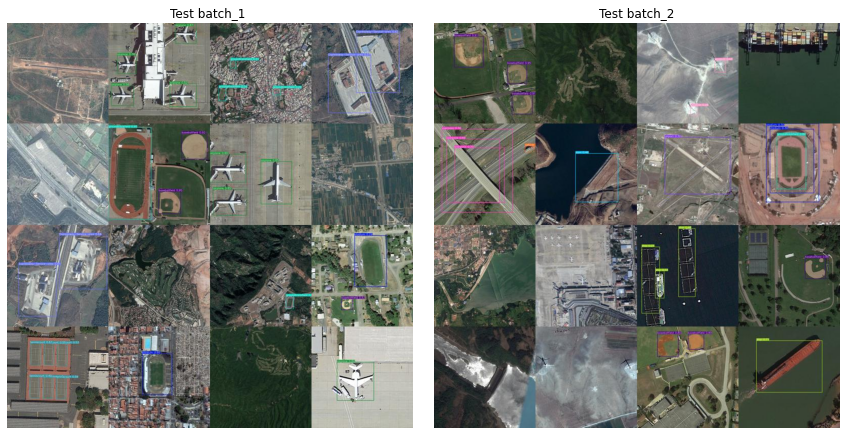

In [116]:


# Specify the paths to the images
val_labels_image_path = r'C:\Users\Oraib\YoloDior\test_batch_1.jpg'
pred_labels_image_path = r'C:\Users\Oraib\YoloDior\test_batch_2.jpg'

# Read the images
val_labels_image = mpimg.imread(val_labels_image_path)
pred_labels_image = mpimg.imread(pred_labels_image_path)

# Create a figure with two subplots side by side
fig, axs = plt.subplots(1, 2, figsize=(12, 6))

# Plot the first image (validation labels)
axs[0].imshow(val_labels_image)
axs[0].set_title('Test batch_1 ')
axs[0].axis('off')

# Plot the second image (prediction labels)
axs[1].imshow(pred_labels_image)
axs[1].set_title('Test batch_2')
axs[1].axis('off')

# Adjust layout to prevent overlap of subplots
plt.tight_layout()

# Show the plot
plt.show()
